In [33]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [34]:
def solve_tov(central_pressure, K_NS=100, max_radius=50):
    """
    Solves the Tolman-Oppenheimer-Volkoff (TOV) equation for a given central pressure
    using a polytropic equation of state: p = K_NS * rho^2.
    """
    pressure_limit = 1e-8
    def _tov_equations(r, y):
        """
        Computes right-hand sides for the TOV ODE system.
        """
        
        dydr = np.zeros_like(y)
        rho = np.sqrt(y[2] / K_NS)  # from p = K_NS * rho^2

        # dm/dr
        dydr[0] = 4.0 * np.pi * (r ** 2) * rho

        # Avoid division by zero at r = 0
        if r == 0.0:
            dydr[1] = 0.0
            dydr[2] = 0.0
        else:
            # dv/dr
            dydr[1] = 2.0 * (y[0] + 4.0 * np.pi * (r ** 3) * y[2]) / (r * (r - 2.0 * y[0]))
            # dp/dr
            dydr[2] = -0.5 * (y[2] + rho) * dydr[1]

        return dydr

    # Initial conditions: mass=0, v=0, p=central_pressure
    y0 = np.array([0.0, 0.0, central_pressure], dtype=float)

    # Solve from r=0 to r=max_radius
    result = solve_ivp(
        fun=_tov_equations,
        t_span=(0.0, max_radius),
        y0=y0,
        method='RK45'
    )

    # Check if pressure has dropped below threshold at final integration point
    if result.y[2, -1] > pressure_limit:
        return None, None
    else:
        # Return radius in km and mass in solar masses
        final_radius = result.t[-1]    # in km
        final_mass = result.y[0, -1]  # in dimensionless "mass" units
        return final_radius, final_mass

In [35]:
def solve_tov_with_baryonic_mass(central_pressure, K_NS=100, max_radius=50):
    """
    Solves the TOV equation for a given central pressure, including baryonic mass 
    (often referred to as the rest mass).
    """
    pressure_limit = 1e-8
    def _tov_equations_baryonic_mass(r, y):
        """
        Computes right-hand sides for the TOV ODE system, including baryonic mass.
        """
        dydr = np.zeros_like(y)
        rho = np.sqrt(y[2] / K_NS)  # from p = K_NS * rho^2

        # dm/dr
        dydr[0] = 4.0 * np.pi * (r ** 2) * rho

        if r == 0.0:
            dydr[1] = 0.0
            dydr[2] = 0.0
            dydr[3] = 0.0
        else:
            # dv/dr
            dydr[1] = 2.0 * (y[0] + 4.0 * np.pi * (r ** 3) * y[2]) / (r * (r - 2.0 * y[0]))
            # dp/dr
            dydr[2] = -0.5 * (y[2] + rho) * dydr[1]
            # dm_baryonic/dr
            dydr[3] = 4.0 * np.pi * (1.0 - 2.0 * y[0] / r) ** (-0.5) * (r ** 2) * rho

        return dydr
    # Initial conditions: mass=0, v=0, p=central_pressure, m_baryonic=0
    y0 = np.array([0.0, 0.0, central_pressure, 0.0], dtype=float)

    # Solve from r=0 to r=max_radius
    result = solve_ivp(
        fun=_tov_equations_baryonic_mass,
        t_span=(0.0, max_radius),
        y0=y0,
        method='RK45'
    )

    if result.y[2, -1] > pressure_limit:
        return None, None, None
    else:
        final_radius = result.t[-1]     # in km
        final_mass = result.y[0, -1]    # dimensionless "mass" units
        final_baryonic_mass = result.y[3, -1]
        return final_radius, final_mass, final_baryonic_mass

In [36]:
def plot_mass_radius(radius_values, mass_values):
    """
    Plots the Mass vs. Radius curve.
    """
    plt.figure(figsize = (6, 4))
    plt.scatter(radius_values * 1.477, mass_values, label = 'Data')
    plt.plot(radius_values * 1.477, mass_values, '--', color = 'red', label = 'Fit')
    plt.xlabel('Radius (km)')
    plt.ylabel('Mass (Solar Mass)')
    plt.legend()
    plt.title('Mass vs. Radius')
    plt.grid()
    plt.show()

In [37]:
def plot_fractional_binding_energy(radius_values, delta_values):
    """
    Plots the fractional binding energy vs. Radius.
    """
    plt.figure(figsize = (6, 4))
    plt.scatter(radius_values * 1.477, delta_values, color = 'blue', label = 'Data')
    plt.plot(radius_values * 1.477, delta_values, '--', color = 'magenta', label = 'Fit')
    plt.xlabel('Radius (km)')
    plt.ylabel('Fractional Binding Energy')
    plt.legend()
    plt.title('Fractional Binding Energy')
    plt.grid()
    plt.show()

In [38]:
def plot_central_density_vs_mass(rho_c_values, mass_values, density_constant):
    """
    Plots the central density vs. mass curve.
    """
    plt.figure(figsize = (6, 4))
    plt.scatter(rho_c_values * density_constant, mass_values, color = 'green', label = 'Data')
    plt.plot(rho_c_values * density_constant, mass_values, '--', color = 'red', label='Fit')
    plt.xlabel('Central Density (kg/m^3)')
    plt.ylabel('Mass (Solar Mass)')
    plt.legend()
    plt.title('Central Density vs. Mass')
    plt.grid()
    plt.show()

In [39]:
def plot_stable_unstable_branches(radius_values, mass_values, max_mass_index):
    """
    Plots the stable and unstable branches of neutron stars in the Mass vs. Radius curve.
    """
    plt.figure(figsize = (6, 4))
    plt.scatter(radius_values * 1.477, mass_values, color = 'magenta', label='Data')
    plt.plot(radius_values[:max_mass_index] * 1.477, mass_values[:max_mass_index], '--', color = 'green', label = 'Stable')
    plt.plot(radius_values[max_mass_index:] * 1.477, mass_values[max_mass_index:], '--', color = 'blue', label = 'Unstable')
    plt.xlabel('Radius (km)')
    plt.ylabel('Mass (Solar Mass)')
    plt.legend()
    plt.title('Stable and Unstable Branches')
    plt.grid()
    plt.show()

----- Part A -----


C:\Users\kubra\AppData\Local\Temp\ipykernel_23256\425652926.py:42: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(y[2] / K_NS)  # from p = K_NS * rho^2


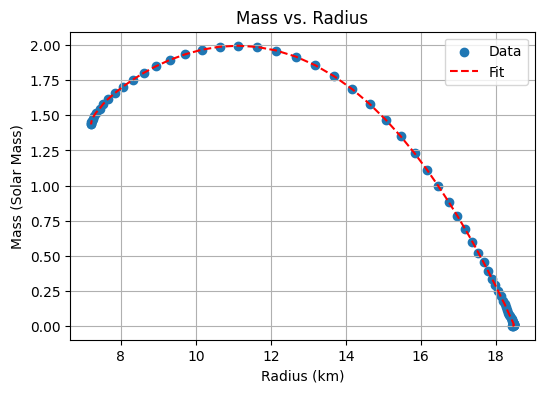

----- Part B -----


C:\Users\kubra\AppData\Local\Temp\ipykernel_23256\810387273.py:43: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(y[2] / K_NS)  # from p = K_NS * rho^2


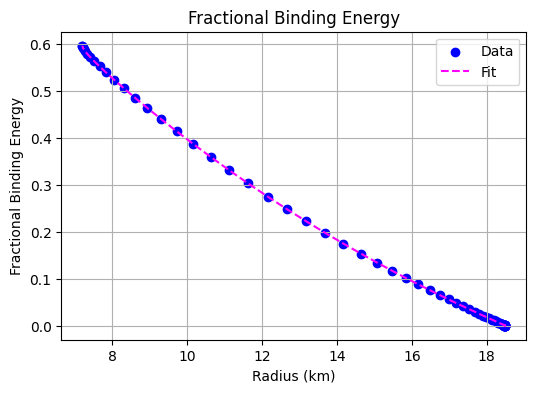

----- Part C -----


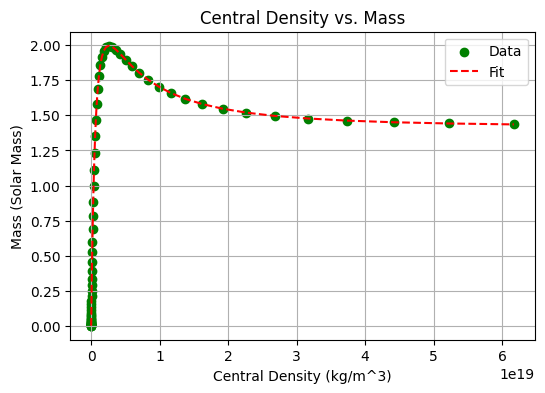

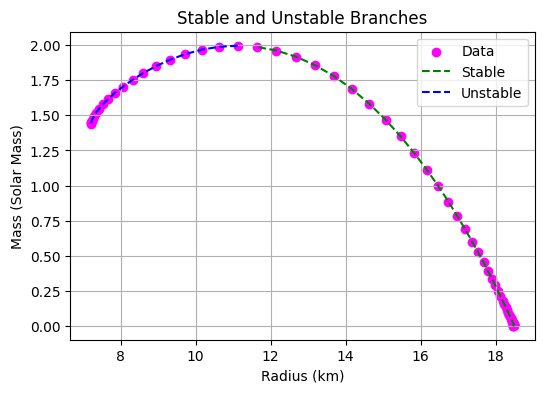

Maximum Neutron Star Mass = 1.995 (Solar Mass)
----- Part D -----


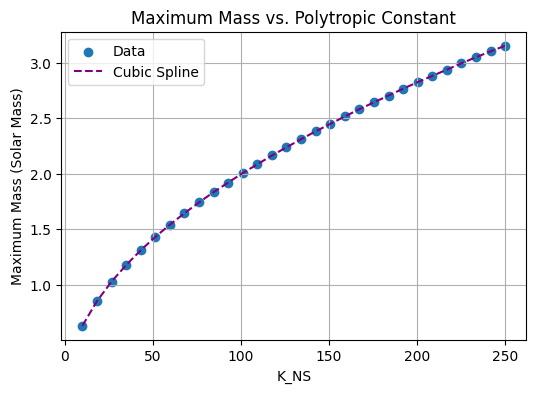

Maximum allowed polytropic constant (for M_max ~ 2.14 Msun) = 115.15


In [41]:
def my_test_einstein():
    M_sun = 1.98847e30  # Solar mass in kg
    R_earth = 6.3781e6  # Earth radius in meters (keeping the name as requested)
    length_unit = 1477.0  # Length unit in meters
    # Part A: Mass-Radius curve
    print("----- Part A -----")
    K_NS_value = 100
    N_samples = 70

    # Create a range of central densities (dimensionless)
    rho_c_values = np.logspace(-6, -1, N_samples)
    # Pressure from p = K_NS * rho^2
    p_c_values = K_NS_value * (rho_c_values ** 2)

    # Solve TOV for each central pressure (no baryonic mass)
    R_values = []
    M_values = []
    for p_c in p_c_values:
        radius, mass = solve_tov(central_pressure=p_c, K_NS=K_NS_value)
        R_values.append(radius)
        M_values.append(mass)

    R_values = np.array(R_values, dtype=float)
    M_values = np.array(M_values, dtype=float)

    # Plot the Mass-Radius curve
    plot_mass_radius(R_values, M_values)

    # Part B: Fractional Binding Energy
    print("----- Part B -----")
    R_values_b = []
    M_values_b = []
    M_p_values_b = []

    # Solve TOV for each central pressure (with baryonic mass)
    for p_c in p_c_values:
        radius, mass, mass_baryonic = solve_tov_with_baryonic_mass(
            central_pressure=p_c, K_NS=K_NS_value
        )
        R_values_b.append(radius)
        M_values_b.append(mass)
        M_p_values_b.append(mass_baryonic)

    R_values_b = np.array(R_values_b, dtype=float)
    M_values_b = np.array(M_values_b, dtype=float)
    M_p_values_b = np.array(M_p_values_b, dtype=float)

    # Fractional binding energy
    delta_values = (M_p_values_b - M_values_b) / M_values_b
    plot_fractional_binding_energy(R_values_b, delta_values)

    # Part C: Central Density vs Mass
    print("----- Part C -----")
    density_constant = M_sun / (length_unit ** 3)
    # We can reuse M_values_b from Part B for mass since it should be the same set
    plot_central_density_vs_mass(rho_c_values, M_values_b, density_constant)

    # Plot stable and unstable branches
    max_mass_index = M_values_b.argmax()
    plot_stable_unstable_branches(R_values_b, M_values_b, max_mass_index)
    print(f"Maximum Neutron Star Mass = {M_values_b[max_mass_index]:.3f} (Solar Mass)")

    # Part D: Maximum mass for different K_NS values
    print("----- Part D -----")
    N_K_NS_samples = 30
    K_NS_values = np.linspace(10, 250, N_K_NS_samples)
    max_masses = []

    for k_val in K_NS_values:
        # For each K_NS, recalculate the central pressures
        p_c_values_temp = k_val * (rho_c_values ** 2)
        local_masses = []
        for p_c in p_c_values_temp:
            _, mass_temp = solve_tov(central_pressure=p_c, K_NS=k_val)
            local_masses.append(mass_temp)
        max_masses.append(np.nanmax(local_masses))  # safeguard with nanmax

    max_masses = np.array(max_masses, dtype=float)
    spline = CubicSpline(K_NS_values, max_masses)

    # We want to find K_NS such that the maximum mass is ~2.14 Msun
    def find_k_ns_for_mass(target_k):
        return spline(target_k) - 2.14

    # Initial guess for K_NS is 100
    K_max_value = fsolve(find_k_ns_for_mass, x0=100)

    plt.figure(figsize = (6, 4))
    plt.scatter(K_NS_values, max_masses, label = 'Data')
    plt.plot(K_NS_values, spline(K_NS_values), '--', color = 'purple', label = 'Cubic Spline')
    plt.xlabel('K_NS')
    plt.ylabel('Maximum Mass (Solar Mass)')
    plt.legend()
    plt.title('Maximum Mass vs. Polytropic Constant')
    plt.grid()
    plt.show()

    print(f"Maximum allowed polytropic constant (for M_max ~ 2.14 Msun) = {K_max_value[0]:.2f}")
my_test_einstein()